In [1]:
#https://www.kaggle.com/datasets/davidcariboo/player-scores

import pandas as pd
pd.set_option("display.float_format", "{:.2f}".format)

# tabular data in CSV format
players = pd.read_csv("players.csv")

# at least 500 objects
print(f"Num of objects: {players.shape[0]}")

print("-----------------------------------")

# 5 continuous variables
print(f"Height [height of the player, in cm], ratio: {players["height_in_cm"][0]}")
print(f"Date of birth [date of brith of the player], interval: {players["date_of_birth"][0]}")
print(f"Market value [current market value the player has attained, EUR], ratio: {players["market_value_in_eur"][0]}")
print(f"Highest market value [highest market value the player had attained, EUR], ratio: {players["highest_market_value_in_eur"][0]}")
print(f"Last season played [last season the player played in, year], interval: {players["last_season"][0]}")

print("-----------------------------------")

# 3 categorical variables
print(f"Name [name of the player], nominal: {players["name"][0]}")
print(f"Foot [player's primary foot], nominal: {players["foot"][0]}")
print(f"Country of birth [player's country of birth], nominal: {players["country_of_birth"][0]}")

print("-----------------------------------")

# dropping redundant columns.. explained later
cols = players.columns.drop(["first_name", "last_name", "image_url", "url", "current_club_name"])

# id 21131 [no height], id 5078 [dirty country of birth - german shortening of USSR] are good examples 
players.sample(5)[cols]

Num of objects: 34301
-----------------------------------
Height [height of the player, in cm], ratio: 184.0
Date of birth [date of brith of the player], interval: 1978-06-09 00:00:00
Market value [current market value the player has attained, EUR], ratio: 1000000.0
Highest market value [highest market value the player had attained, EUR], ratio: 30000000.0
Last season played [last season the player played in, year], interval: 2015
-----------------------------------
Name [name of the player], nominal: Miroslav Klose
Foot [player's primary foot], nominal: right
Country of birth [player's country of birth], nominal: Poland
-----------------------------------


,player_id,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,current_club_domestic_competition_id,market_value_in_eur,highest_market_value_in_eur
1068,13292,Benjamin De Ceulaer,2016,968,benjamin-de-ceulaer,Belgium,Genk,Belgium,1983-12-19 00:00:00,Centre-Forward,Attack,right,174.00,NaN,NaN,BE1,200000.00,3000000.00
10104,149579,Elbasan Rashani,2023,3524,elbasan-rashani,Sweden,Hillerstorp,Kosovo,1993-05-09 00:00:00,Left Winger,Attack,left,181.00,2025-06-30 00:00:00,RGFOOTBALL,FR1,1500000.00,2500000.00
186,3322,Ben Williams,2013,903,ben-williams,England,Manchester,England,1982-08-27 00:00:00,Goalkeeper,Goalkeeper,left,188.00,NaN,NaN,SC1,100000.00,500000.00
3381,39705,Nicky Maynard,2017,370,nicky-maynard,England,Winsford,England,1986-12-11 00:00:00,Centre-Forward,Attack,right,180.00,NaN,NaN,SC1,300000.00,4000000.00
11278,176139,Mattia Bani,2023,252,mattia-bani,Italy,Borgo San Lorenzo,Italy,1993-12-10 00:00:00,Centre-Back,Defender,right,188.00,2026-06-30 00:00:00,NaN,IT1,2500000.00,3200000.00


In [2]:
# detect missing values

# make all empty rows into NA's
players.replace("", pd.NA, inplace=True)

nans = players.isna().sum()
nansPercentage = (nans / len(players)) * 100

missingTable = pd.DataFrame({"Missing": nans,
             "Percentage missing": nansPercentage.round(2)})

display(missingTable)

# possible reasons for some things missing
# first name may be a calculated field - name is the primary one,
# country of birth as well as city of birth may not be collected by local clubs
# foot, height may only be collected in more major leagues
# contracts & value are likely missing in smaller leagues / clubs
# agent is empty because having one is not mandatory, so missing field in this case likely means player just has no agent.

# with a percentage less than 5 %, we can likely drop this subset of data
# another option for interval or ratio types is to replace data with, say, the median
# players["height_in_cm"].fillna(players["height_in_cm"].median(), inplace=True)
# for nominals or ordinals, introducing a new value that describes an unknown value is an option too
# players["agent_name"].fillna("No Agent / Unknown", inplace=True)

# for this specific dataset, since more countries of birth are missing compared to cities of birth, that data can be extrapolated too.
# len(players.loc[players["country_of_birth"].isna() & players["city_of_birth"].notna()])

,Missing,Percentage missing
player_id,0,0.00
first_name,2134,6.22
last_name,0,0.00
name,0,0.00
last_season,0,0.00
current_club_id,0,0.00
player_code,0,0.00
country_of_birth,2915,8.50
city_of_birth,2590,7.55
country_of_citizenship,353,1.03


In [3]:
# can only see people who are in the range above IQR, market value
Q1 = players["market_value_in_eur"].quantile(0.25)
Q3 = players["market_value_in_eur"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print(f"Lower bound is {lower}, upper bound is {upper}") 
outliers = players[
    (players["market_value_in_eur"] < lower) |
    (players["market_value_in_eur"] > upper)
]
display(outliers["market_value_in_eur"])

# market value can be very skewed - low market value belongs to juniors, recruits, while high value belongs to elite players - no grounding means the value varies wildly

# ditto, height
Q1 = players["height_in_cm"].quantile(0.25)
Q3 = players["height_in_cm"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print(f"Lower bound is {lower}, upper bound is {upper}") 
outliers = players[
    (players["height_in_cm"] < lower) |
    (players["height_in_cm"] > upper)
]
display(outliers["height_in_cm"])

# in this case, using solely IQR would remove far too much data
# instead, data could be removed based on biological presumptions (no players below 145cm / above 220cm, no players older than 55...)
# market value could have its log(1 + x) taken, to accomodate the values into a more acceptable range.

Lower bound is -800000.0, upper bound is 1600000.0


29       2000000.00
103     11000000.00
134      2500000.00
138      1750000.00
143      2000000.00
            ...    
34108    4000000.00
34170   12000000.00
34185    3500000.00
34198    2000000.00
34203    3000000.00
Name: market_value_in_eur, Length: 4478, dtype: float64

Lower bound is 164.5, upper bound is 200.5


298     201.00
411     164.00
2312    205.00
2565    159.00
3065    164.00
         ...  
33788   203.00
33899   202.00
33912   164.00
34059   161.00
34187   164.00
Name: height_in_cm, Length: 154, dtype: float64

In [4]:
print(players.columns)

# first_name & last_name can be derived from name, so not needed
# image_url, url are metadata, so also not needed
# current_club_name can be dropped in favor of querying the club name using current_club_id (if the other dataset is present)
# player code is also possibly arbitrary data which, if needed, can possibly be reverse engineered, but likely not needed

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='str')


In [5]:
# additional self-made ordinal variable
players["value_category"] = pd.cut(
    players["market_value_in_eur"],
    bins=[0, 1_000_000, 10_000_000, 100_000_000],
    labels=["low", "medium", "high"]
).cat.add_categories("unknown").fillna("unknown")

print(f"Value category [the value category (unknown/low/medium/high) of the player according to market value], ordinal: {players["value_category"][0]}")

# additional self-made ratio variable
dob = pd.to_datetime(players["date_of_birth"], errors="coerce")
today = pd.Timestamp.today().normalize()
players["age"] = (
    today.year
    - dob.dt.year
    - ((today.month < dob.dt.month) |
        ((today.month == dob.dt.month) & (today.day < dob.dt.day)))
)
print(f"Age [age of the player], ratio: {players["age"][0]}")

cols = list(cols)
cols = cols + ["age", "value_category"]
players[cols].sample(3)

Value category [the value category (unknown/low/medium/high) of the player according to market value], ordinal: low
Age [age of the player], ratio: 47.0


,player_id,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,current_club_domestic_competition_id,market_value_in_eur,highest_market_value_in_eur,age,value_category
17876,322655,Flavius Daniliuc,2024,276,flavius-daniliuc,Austria,Wien,Austria,2001-04-27 00:00:00,Centre-Back,Defender,right,188.00,2028-06-30 00:00:00,YOU FIRST,IT1,6000000.00,8000000.00,24.00,medium
34205,1314350,Kenay Myrie,2025,190,kenay-myrie,Costa Rica,Alajuela,Costa Rica,2006-09-06 00:00:00,Right-Back,Defender,right,188.00,2030-06-30 00:00:00,PROSPORT Management,DK1,400000.00,400000.00,19.00,low
5108,58228,Marinho,2015,2990,marinho,Portugal,Lisboa,Portugal,1983-04-26 00:00:00,Right Winger,Attack,left,166.00,NaN,NaN,PO1,25000.00,1500000.00,42.00,low


In [6]:
# basic statistics...
analysisCols = ["height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "age"]

numeric = players[analysisCols]

summary = pd.DataFrame({
    "count": numeric.count(),
    "mean": numeric.mean(),
    "variance": numeric.var(),
    "std": numeric.std(),
    "min": numeric.min(),
    "skew": numeric.skew(),
    "kurt": numeric.kurtosis(),
    "25%": numeric.quantile(0.25),
    "median / 50%": numeric.median(),
    "75%": numeric.quantile(0.75),
    "max": numeric.max()
})

print(players["value_category"].mode())
display(summary)

0    low
Name: value_category, dtype: category
Categories (4, str): ['low' < 'medium' < 'high' < 'unknown']


,count,mean,variance,std,min,skew,kurt,25%,median / 50%,75%,max
height_in_cm,31905,182.37,48.44,6.96,18.00,-1.68,38.10,178.00,183.00,187.00,210.00
market_value_in_eur,31395,1665981.37,42269816817356.80,6501524.19,10000.00,10.99,189.74,100000.00,250000.00,700000.00,200000000.00
highest_market_value_in_eur,31395,3770169.77,96120317687937.62,9804096.98,10000.00,7.00,75.45,300000.00,800000.00,3000000.00,200000000.00
age,34252,30.09,46.79,6.84,15.00,0.41,-0.42,25.00,29.00,35.00,57.00


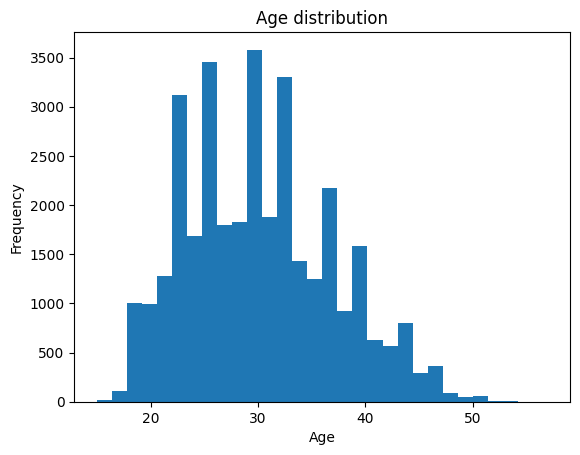

In [7]:
import matplotlib.pyplot as plt

plt.hist(players["age"].dropna(), bins=30)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

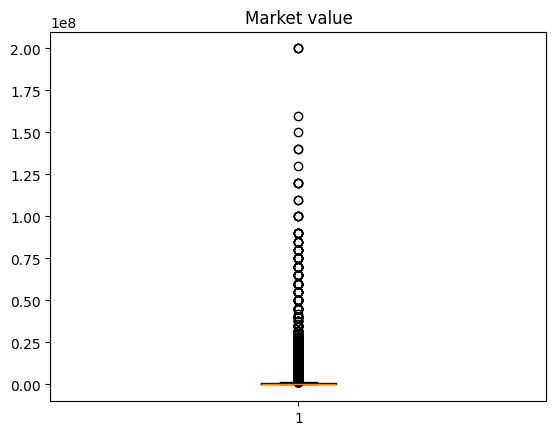

In [8]:
plt.boxplot(players["market_value_in_eur"].dropna())
plt.title("Market value")
plt.show()

12.429220196836383


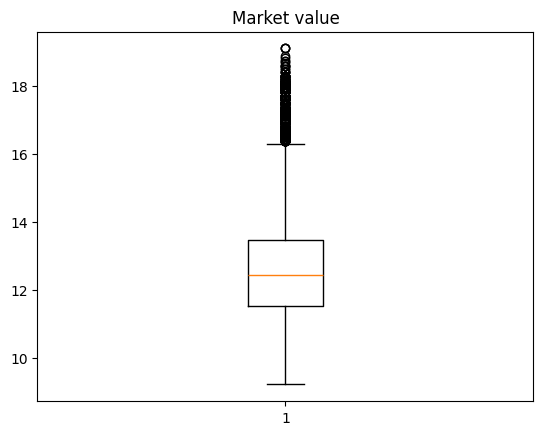

In [ ]:
import numpy as np

# let's get our log(1 + x) we mentioned earlier
players["log_market_value"] = np.log1p(players["market_value_in_eur"])
plt.boxplot(players["log_market_value"].dropna())
plt.title("Market value")
plt.show()

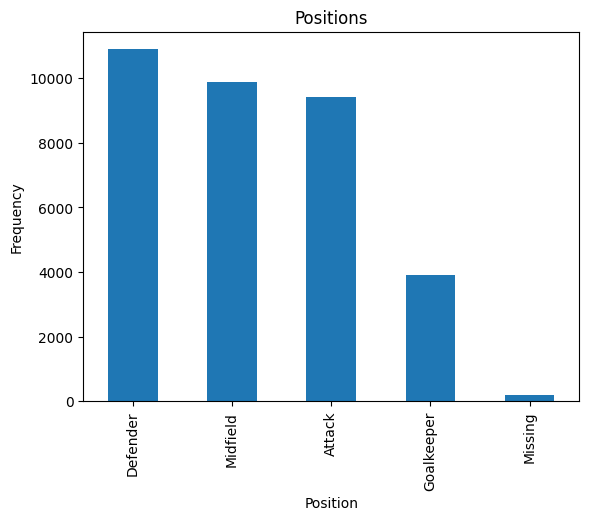

In [ ]:
players["position"].value_counts().plot(kind="bar")
plt.title("Positions")
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.show()

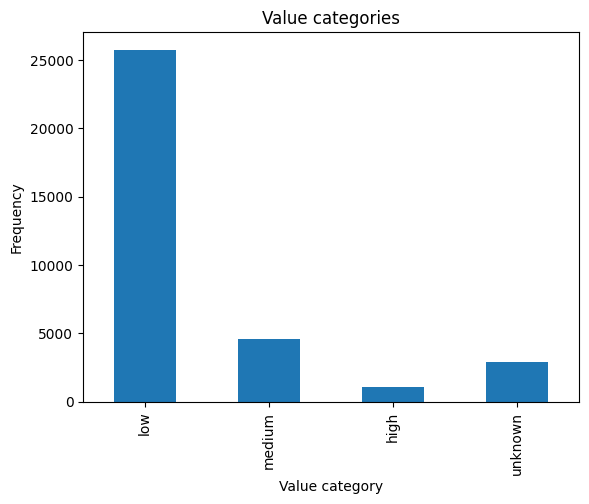

In [ ]:
players["value_category"].value_counts().sort_index().plot(kind="bar")
plt.title("Value categories")
plt.xlabel("Value category")
plt.ylabel("Frequency")
plt.show()

In [ ]:
display(players[["age", "height_in_cm", "market_value_in_eur"]].corr())
display(players[["age", "height_in_cm", "market_value_in_eur"]].cov())

,age,height_in_cm,market_value_in_eur
age,1.00,-0.02,-0.16
height_in_cm,-0.02,1.00,0.01
market_value_in_eur,-0.16,0.01,1.00


,age,height_in_cm,market_value_in_eur
age,46.80,-0.92,-6917000.24
height_in_cm,-0.92,48.44,343185.12
market_value_in_eur,-6917000.24,343185.12,42269816817356.68


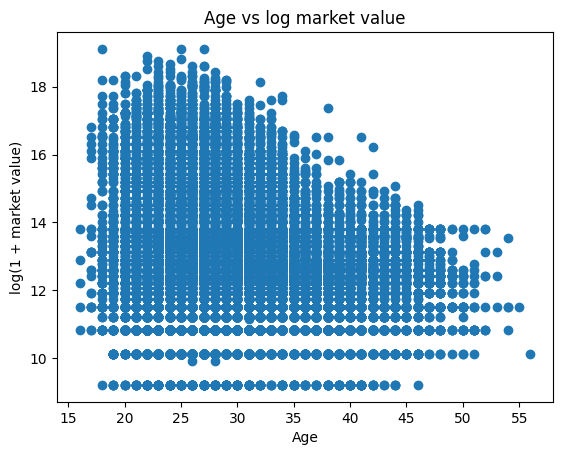

In [ ]:
plt.scatter(players["age"], players["log_market_value"])
plt.xlabel("Age")
plt.ylabel("log(1 + market value)")
plt.title("Age vs log market value")
plt.show()

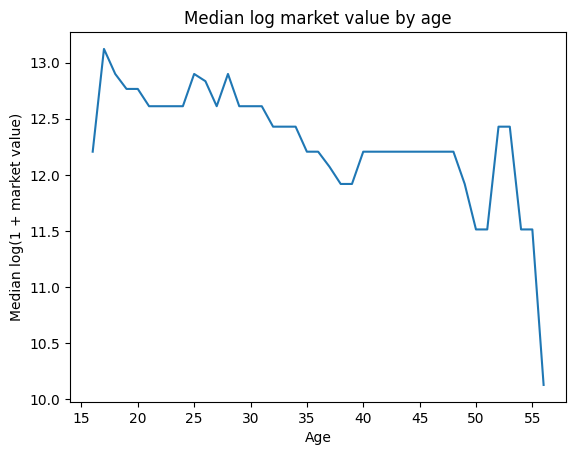

In [ ]:
medianByAge = players.groupby("age")["log_market_value"].median()

plt.plot(medianByAge.index, medianByAge.values)
plt.xlabel("Age")
plt.ylabel("Median log(1 + market value)")
plt.title("Median log market value by age")
plt.show()

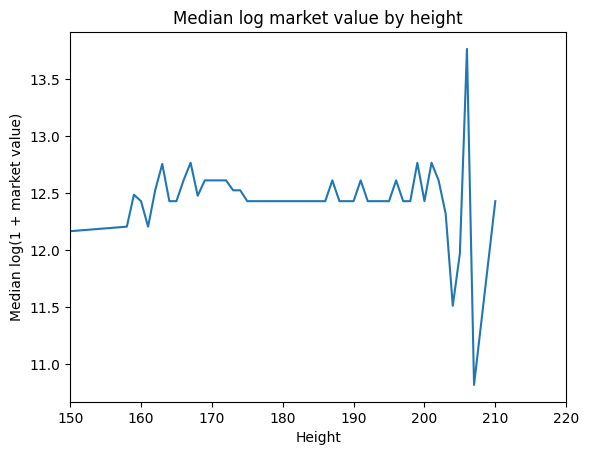

In [ ]:
medianByHeight = players.groupby("height_in_cm")["log_market_value"].median()

plt.plot(medianByHeight.index, medianByHeight.values)
plt.xlabel("Height")
plt.xlim([150, 220])
plt.ylabel("Median log(1 + market value)")
plt.title("Median log market value by height")
plt.show()

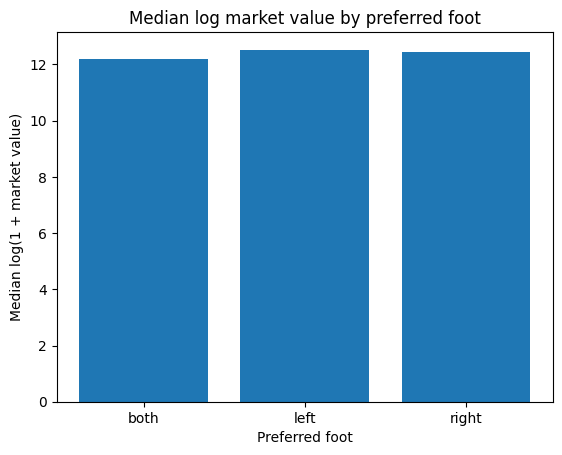

In [ ]:
medianByFoot = players.groupby("foot")["log_market_value"].median()

plt.bar(medianByFoot.index, medianByFoot.values)
plt.xlabel("Preferred foot")
plt.ylabel("Median log(1 + market value)")
plt.title("Median log market value by preferred foot")
plt.show()

# Five aspects
1. Median market value tracks off as the player gets older, though you cannot necessarily consider age the primary factor - club, position and experience play a role too.
2. Most of the market value is concentraded among a small number of elite players who are worth substantially more than the majority of players.
3. Peak player value is often achieved in their mid 20s.
4. There are three orders of magnitude of difference between the most common player market value and the top elite, so looking at logarithmic differences provides more meaningful results than raw values.
5. There does not appear to be a direct relationship between biometric characteristics (height, footedness) and market value.

# Insights
1. Kurtosis and positive skewness of market value in EUR are incredibly high.
2. Value follows a quadratic shape in relation to age, showing that players in mid 20s are valued the highest due to their physical parameters and technical knowledge.
3. Biometric variables have a limited direct impact on a player's valuation.
4. Variances within the same age group are extreme - you can find players earning 100 000, and players earning 10 000 000.
5. The effect of height is rather limited. 